In [1]:
import pandas as pd
import numpy as np
import os
import pycocotools.mask as mutils
import base64
import numpy as np
from pycocotools import mask as coco_mask_d
import typing as t
import zlib
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm

DATA_DIR = '/mnt/chicm/data/open-images/segmentation'

In [2]:
def get_top_classes(start_index, end_index, class_file='top_classes_level1.csv'):
    df = pd.read_csv(os.path.join(DATA_DIR, class_file))
    c = df['class'].values[start_index:end_index]
    #print(df.head())
    stoi = { c[i]: i for i in range(len(c)) }
    return c, stoi


In [3]:
level1_classes = get_top_classes(0, 275)[0]
parent_classes = get_top_classes(0, 25, 'top_classes_parent.csv')[0]

seg_classes = set(level1_classes) | set(parent_classes)
len(seg_classes)

300

In [8]:
len(seg_classes)

300

In [4]:
len(level1_classes)

275

In [28]:
df = pd.read_csv('/mnt/chicm/open-images-vrd/vrd/det/final_det_segm_ensemble_with_more_extra_higher_level_20191001.csv.zip')

In [9]:
#df = pd.read_csv('seg_lb5026_bbox.csv')

In [29]:
df.PredictionString = df.PredictionString.fillna('')

In [30]:
df.head()

,ImageId,PredictionString
0,00000b4dcff7f799,/m/07yv9 0.1014 0.1469 0.1145 0.9360 0.8608 /m...
1,00001a21632de752,/m/07yv9 0.1103 0.0052 0.0577 0.8222 0.9935 /m...
2,0000d67245642c5f,/m/07yv9 0.0457 0.0370 0.0690 0.9413 0.9923 /m...
3,0001244aa8ed3099,/m/07yv9 0.1433 0.0512 0.1449 0.8007 0.7719 /m...
4,000172d1dd1adce0,/m/07yv9 0.1140 0.2272 0.0299 0.8484 0.9221 /m...


In [31]:
def get_dets_by_pred_str(pred_str):
    try:
        if len(pred_str) < 1:
            return []
    except:
        print('pred_str:', pred_str)
        raise
    det_items = pred_str.split(' ')
    dets, det = [], []
    for i in range(len(det_items)):
        det.append(det_items[i])
        if (i+1) % 6 == 0:
            assert '/' in det[0]
            if det[0] in seg_classes:
                dets.append(det)
            det = []
    return sorted(dets, key=lambda x: float(x[1]), reverse=True)[:50]

In [32]:
#sorted(ens_det, key=lambda x: x[2], reverse=True)[:MAX_NUM]

In [33]:
df['dets'] = df.PredictionString.map(lambda x: get_dets_by_pred_str(x))
df.head()

,ImageId,PredictionString,dets
0,00000b4dcff7f799,/m/07yv9 0.1014 0.1469 0.1145 0.9360 0.8608 /m...,"[[/m/07r04, 0.9051, 0.0080, 0.1285, 0.7067, 0...."
1,00001a21632de752,/m/07yv9 0.1103 0.0052 0.0577 0.8222 0.9935 /m...,"[[/m/03bt1vf, 0.6542, 0.2735, 0.6122, 0.5189, ..."
2,0000d67245642c5f,/m/07yv9 0.0457 0.0370 0.0690 0.9413 0.9923 /m...,"[[/m/079cl, 0.2559, 0.1846, 0.0429, 0.9924, 0...."
3,0001244aa8ed3099,/m/07yv9 0.1433 0.0512 0.1449 0.8007 0.7719 /m...,"[[/m/0c9ph5, 0.2090, 0.5508, 0.4451, 0.9990, 0..."
4,000172d1dd1adce0,/m/07yv9 0.1140 0.2272 0.0299 0.8484 0.9221 /m...,"[[/m/04h7h, 0.2846, 0.2505, 0.0348, 0.8005, 0...."


In [34]:
# total
df.dets.map(lambda x: len(x)).values.sum()

4998829

In [12]:
# total
df.dets.map(lambda x: len(x)).values.sum()

9957865

In [35]:
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'

def get_fn(img_id):
    return TEST_IMG_DIR + '/' + img_id + '.jpg'

df['ImageWidth'] = df.ImageId.map(lambda x: get_image_size(get_fn(x))[0])
df['ImageHeight'] = df.ImageId.map(lambda x: get_image_size(get_fn(x))[1])
df.head()

,ImageId,PredictionString,dets,ImageWidth,ImageHeight
0,00000b4dcff7f799,/m/07yv9 0.1014 0.1469 0.1145 0.9360 0.8608 /m...,"[[/m/07r04, 0.9051, 0.0080, 0.1285, 0.7067, 0....",1024,683
1,00001a21632de752,/m/07yv9 0.1103 0.0052 0.0577 0.8222 0.9935 /m...,"[[/m/03bt1vf, 0.6542, 0.2735, 0.6122, 0.5189, ...",1024,681
2,0000d67245642c5f,/m/07yv9 0.0457 0.0370 0.0690 0.9413 0.9923 /m...,"[[/m/079cl, 0.2559, 0.1846, 0.0429, 0.9924, 0....",1024,683
3,0001244aa8ed3099,/m/07yv9 0.1433 0.0512 0.1449 0.8007 0.7719 /m...,"[[/m/0c9ph5, 0.2090, 0.5508, 0.4451, 0.9990, 0...",1024,683
4,000172d1dd1adce0,/m/07yv9 0.1140 0.2272 0.0299 0.8484 0.9221 /m...,"[[/m/04h7h, 0.2846, 0.2505, 0.0348, 0.8005, 0....",1024,682


In [36]:
def get_mask(bbox, h, w):
    b = [float(x) for x in bbox]
    mask = np.zeros((h, w))
    mask[int(b[1]*h):int(b[3]*h), int(b[0]*w):int(b[2]*w)] = 1
    
    return mask.astype(np.bool)

In [37]:
def gen_preds(row):
    res = []
    for det in row.dets:
        bbox = det[2:]
        mask = get_mask(bbox, row.ImageHeight, row.ImageWidth)
        res.append(det[0])
        res.append(det[1])
        #res.append(str(float(det[1])/200))
        res.append(encode_binary_mask(mask))
    return ' '.join(res)

In [38]:
def set_pred_str(df):
    df['PredictionString'] = df.apply(lambda row: gen_preds(row), axis=1)
    return df

In [39]:
df = parallel_apply(df, set_pred_str)

In [40]:
df.iloc[90000].PredictionString

'/m/06z37_ 0.3613 eNrLzzBLyjOwNRgFo2AUjIJRMBxBUro5ANtCHSo= /m/0bt_c3 0.3528 eNoLyzKNzDNIMxgFo2AUjIJRMGxBbIYZAJxKHh0= /m/0d20w4 0.1679 eNrLCckwzMw1CDM0GAWjYBSMgqEJQtMDjQGi5uf3 /m/09rvcxw 0.1469 eNoLD4yxSswyiDMxGM4gMivOEgAl+y2W /m/0fly7 0.1200 eNqLjkoxyMszMDQYBaNgFIyCUUAvkBAXZwgASy4Jcw== /m/0k5j 0.1180 eNoLjwm0ysoyCDUxGLkgIy/KEgDDZDNF /m/07mhn 0.1179 eNpLjk00SMkzsDYYBaNgFIyCUTBYQEZ2oCEA+AcPgw== /m/06y5r 0.0989 eNrLzk6wisgySDcxGG4gPjPeEgBBoyuO /m/0k1tl 0.0858 eNrLSUu1Cs82yDA2GPogPD3REgD6Kyjn /m/01n4qj 0.0696 eNqLSLRLyTGINjIYBaNgFIyCUTCUQGpUsgEAVMsWNg== /m/0d20w4 0.0695 eNoLD4q2Cs42yDE2GO4gOjvWEgDbri5Y /m/0frqm 0.0550 eNrLS7QNyzPINBgFo2AUjIJRMERBSLw9AJjJF8s= /m/01bms0 0.0503 eNrLTku1ysg0CDc1GNogLDXZEgBZaigl /m/04ylt 0.0410 eNqLCQu3CswyyDMxGFkgNi/KEgB0xTD/ /m/04dr76w 0.0405 eNqLi000SM0zsDIYBaNgFIyCgQOp8aGmAANv3Gg= /m/01d40f 0.0350 eNrLTsiyTM4zsDEYBaNgFFACIsLTDQD3GKCC /m/01d40f 0.0337 eNrLj042yM41CDE0GAWjYBSMAtJAXmSEGQBvic6Q /m/04ctx 0.0336 eNoLS0+xSss2iDQ2GB4gPyPBEgCLrSmp /m/04dr76w 0.0335 

In [41]:
df.head()

,ImageId,PredictionString,dets,ImageWidth,ImageHeight
0,00000b4dcff7f799,/m/07r04 0.9051 eNqLjzUNSDCINjUYBaNgFIyCUTBYQE...,"[[/m/07r04, 0.9051, 0.0080, 0.1285, 0.7067, 0....",1024,683
1,00001a21632de752,/m/03bt1vf 0.6542 eNrLSM4yDbUIsTUYBSMNpMaFWwEA...,"[[/m/03bt1vf, 0.6542, 0.2735, 0.6122, 0.5189, ...",1024,681
2,0000d67245642c5f,/m/079cl 0.2559 eNrLCcozjk4xCDA0GAWjYBSMglEwCu...,"[[/m/079cl, 0.2559, 0.1846, 0.0429, 0.9924, 0....",1024,683
3,0001244aa8ed3099,/m/0c9ph5 0.2090 eNqLic+wTrNOtTQYBaNgFAweEBZoC...,"[[/m/0c9ph5, 0.2090, 0.5508, 0.4451, 0.9990, 0...",1024,683
4,000172d1dd1adce0,/m/04h7h 0.2846 eNpLT4gyjUo0CDAxGAWjYBSMAtqB6I...,"[[/m/04h7h, 0.2846, 0.2505, 0.0348, 0.8005, 0....",1024,682


In [42]:
df.rename(columns={'ImageId': 'ImageID'}, inplace=True)
df.head()

,ImageID,PredictionString,dets,ImageWidth,ImageHeight
0,00000b4dcff7f799,/m/07r04 0.9051 eNqLjzUNSDCINjUYBaNgFIyCUTBYQE...,"[[/m/07r04, 0.9051, 0.0080, 0.1285, 0.7067, 0....",1024,683
1,00001a21632de752,/m/03bt1vf 0.6542 eNrLSM4yDbUIsTUYBSMNpMaFWwEA...,"[[/m/03bt1vf, 0.6542, 0.2735, 0.6122, 0.5189, ...",1024,681
2,0000d67245642c5f,/m/079cl 0.2559 eNrLCcozjk4xCDA0GAWjYBSMglEwCu...,"[[/m/079cl, 0.2559, 0.1846, 0.0429, 0.9924, 0....",1024,683
3,0001244aa8ed3099,/m/0c9ph5 0.2090 eNqLic+wTrNOtTQYBaNgFAweEBZoC...,"[[/m/0c9ph5, 0.2090, 0.5508, 0.4451, 0.9990, 0...",1024,683
4,000172d1dd1adce0,/m/04h7h 0.2846 eNpLT4gyjUo0CDAxGAWjYBSMAtqB6I...,"[[/m/04h7h, 0.2846, 0.2505, 0.0348, 0.8005, 0....",1024,682


In [43]:
df.to_csv('od628_mask_300_top50.csv', columns=['ImageID', 'ImageWidth', 'ImageHeight', 'PredictionString'], index=False)

In [75]:
df.head()

,ImageID,PredictionString
0,80155d58d0ee19bd,/m/01k6s3 0.4164521 0.25684 0.26940 0.72363 0....
1,52a76f3fe21185bf,/m/03y6mg 0.2951875 0.61914 0.04685 0.97559 0....
2,65e9da7c04c8e4cd,/m/01lrl 0.0051426 0.00195 0.87537 0.14355 0.9...
3,6d10fa21d93bd6cc,/m/01xyhv 0.9428729 0.53125 0.25073 0.88379 0....
4,0841dee573a875ca,/m/0342h 0.8243405 0.45898 0.49780 0.71582 0.7...


In [81]:
tmp_mask = get_mask(df.iloc[1].PredictionString.split(' ')[8:12], 683, 1024)

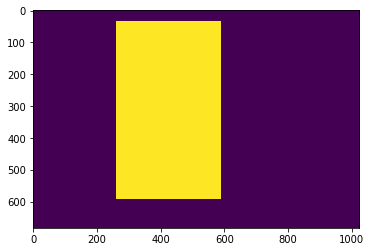

In [82]:
plt.imshow(tmp_mask)

In [16]:
from multiprocessing import Pool

def parallel_apply(df, func, n_cores=24):
    #ncores = 24
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [14]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            raise AssertionError('imghead len != 24')
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                raise AssertionError('png check failed')
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                raise
        else:
            print(fname, imghdr.what(fname))
            #raise AssertionError('file format not supported')
            img = cv2.imread(fname)
            print(img.shape)
            height, width, _ = img.shape

        return width, height


In [15]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)
    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode('utf-8')
